| | |
|--|--|
| **Names** | *Fill in your names here* |
| **Group** | *Report your group number here* |

In [2]:
%matplotlib inline
import numpy as np
import operator
import pylab

pylab.rcParams['figure.figsize'] = (10.0, 8.0)


In [3]:
x = np.array([[1,2],[3,4],[1,3]])
y = np.array([[5,6]])
print np.sort(x, axis=0)
z = np.concatenate((x,y.T),axis=1)
print z

print z[:,2]

[[1 2]
 [1 3]
 [3 4]]


ValueError: all the input array dimensions except for the concatenation axis must match exactly

# Decision Trees

In this lab, we will implement the C4.5 algorithm for classification with decision trees. 


## Data

Let's start by loading the datasets that we will be working with. The ```mushroom``` dataset is a dataset describing the features of different species of mushrooms, and the goal is to derive simple rules to predict whether a species is poisonous or not.

In [2]:
# This code is given
data = np.load("uci-mushrooms.npz")
# data = np.load("hiv.npz")
print data.keys()

d = data['inputs']
l = data['targets']
fname = data['feature_names']
print fname

['inputs', 'targets', 'feature_names']
['cap-shape' 'cap-surface' 'cap-colour' 'bruises?' 'odour'
 'gill-attachment' 'gill-spacing' 'gill-size' 'gill-colour' 'stalk-shape'
 'stalk-root' 'stalk-surface-above-ring' 'stalk-surface-below-ring'
 'stalk-colour-above-ring' 'stalk colour-below-ring' 'veil type'
 'veil colour' 'Number-of-rings' 'Type-of-ring' 'spore-print-colour'
 'population' 'habitat']


## Helper functions

Here are a few functions to deal with categorical labels

In [3]:
# This code is given

def listValues(inputlist):
    """List the possible values of a given feature in a dataset"""
    values = set([])
    for x in inputlist:
        values.add(x)
    return list(values)

def countLabels(labelList):
    """Return the most common label in a list"""
    counts = {}
    for x in labelList:
        if x not in counts:
            counts[x] = 1
        else:
            counts[x] += 1
    return counts

def majorityLabel(labelList):
    counts = countLabels(labelList)
#    print "Majority label:", counts
    return max(counts.iteritems(), key=operator.itemgetter(1))[0]


print listValues(l)
print listValues(d[:,0])
print majorityLabel(d[:,1])

['POISONOUS', 'EDIBLE']
['FLAT', 'SUNKEN', 'BELL', 'KNOBBED', 'CONVEX', 'CONICAL']
SCALY


## Computing the entropy of a list of categorical values

The decision tree makes its decision based on decision nodes, and these nodes are evaluated based on information gain they provide on the training data. Information gain is computed as 
$$
IG = H(parent) - \sum_j \frac{N_j}{N} H(child=j)
$$
the entropy of the data associated with the parent, minus the weighted entropy of the data-subsets associated with the chidlren

**question 1 [5 credits]]** Implement a helper function that computes the entropy of a set of categorical labels


In [4]:
# This code is not given

def entropy(labelList):
    counts = countLabels(labelList)
#    print counts
    total = float(sum(counts.values()))
    res = 0.
    for c in counts:
        p = counts[c]/total
        res -=  p * np.log2(p)
    return res

print entropy(l)
               

0.996803828522


## Implementing the tree

Below, you are given the code to make a decision tree, train it and classify datapoints using binary decision nodes based on categorical variables. The implementation includes  ```Leaf``` nodes, wich return a classification result, and ```BinaryNode```, which decide which child should be responsible for the further classification.

The ```BinaryNode``` constructor selects the most informative value in the data it's trained on, and makes a decision based on whether or not the feature of the datapoint to be classified equals that value, or not.

In [5]:
# This code is given

class Node:
    def classify(self, datapoint):
        """Return the classification label for the given datapoint"""
        raise Exception("Not Implemented")        
    def entropy(self):
        """Return the entropy of the training data associated with this node"""
    def informationGain(self):
        """Return the information gain of this node on the training data """
        raise Exception("Not Implemented by derived class")

class Leaf(Node):
    def __init__(self,inputs, targets):
#        print "Inputs, targets:", inputs.shape, targets.shape
        
        self.v = majorityLabel(targets)
        self.inputs = inputs
        self.targets = targets
        self.children = None
        self.H = entropy(targets)
        
    def entropy(self):
        return self.H
    
    def informationGain(self):
        return 0.
    
    def classify(self,datapoint):
        return self.v
    
    def __str__(self):
        return "\t\t\t=> %s [Leaf]" % (self.v)
    
class BinaryNode(Node):
    """Make a decision based on whether a given feature equals a given value, or not"""
    def __init__(self, inputs, targets, feature):
        self.feature = feature
        self.value   = None
        self.IG      = 0.0
        self.H       = entropy(targets)                     # Entropy of unsplit data
        self.inputs  = inputs
        self.targets = targets
        N = float(targets.size)                             # Total number of datapoints

        for value in listValues(inputs[:,feature]):
            indicesTrue  = inputs[:,feature]==value
            indicesFalse = inputs[:,feature]!=value

            if indicesTrue.all() or indicesFalse.all():
                continue

            children = [ Leaf(inputs[indicesTrue,:], targets[indicesTrue]),
                         Leaf(inputs[indicesFalse,:], targets[indicesFalse]) ]
            conditions = [ "%s==%s" % (fname[feature], value), "%s!=%s" % (fname[feature], value) ]

            Nt = float(children[0].targets.size)        # N.o. datapoints in True condition
            Nf = float(children[1].targets.size)        # N.o. datapoints in False condition
            pt = Nt/N
            pf = Nf/N
            ig = self.H - pt * children[0].entropy() - pf * children[1].entropy()
            
            if ig > self.IG:
                self.value = value
                self.IG = ig
                self.children = children
                self.conditions = conditions
    
    def entropy(self):
        return self.H
    
    def informationGain(self):
        """Return the entropy gain of splitting the given data according to 
        the specified feature and value"""
        return self.IG
    
    def classify(self, x):
        if x[self.feature] == self.value:
            return self.children[0].classify(x)
        else:
            return self.children[1].classify(x)
        
    def __str__(self):
        return " => Binary decision: '%s =?= %s'" % (fname[self.feature], self.value )
    
    

In [6]:
# This code is given BUT MUST BE MODIFIED!
import sys
allBinary = [ BinaryNode for i in range(l.size) ]

def c45(inputs, targets, featureType = allBinary, minSize=0):
    ig = 0.
    res = None
    for feature in range(inputs.shape[1]):
        n = featureType[feature](inputs,targets,feature)
        if n.informationGain() > ig:
            ig = n.informationGain()
            res = n
    if not res:
#        print "WARNING: No informative feature found"
        return res
    for i in range(len(res.children)):
        if res.children[i].entropy() > 0. and len(res.children[i].targets) > minSize:
            c = c45(res.children[i].inputs, res.children[i].targets, featureType, minSize)
            if c:
                res.children[i]=c
    return res


root = c45(d,l, allBinary, 2)

In [7]:
# This code is given

def prettyPrint(tree, cond="", dlist = [True]):
    indent = ""
    for d in dlist[:-1]:
        indent += "   " if d else "|  "
    print indent + "+-> " + cond + " " + tree.__str__()
    if tree.children:
        for cond,cld in zip(tree.conditions[:-1],tree.children[:-1]):
            prettyPrint(cld,cond,dlist + [ False ])
        prettyPrint(tree.children[-1], tree.conditions[-1], dlist+[ True ])

    

prettyPrint(root)


+->   => Binary decision: 'odour =?= NONE'
   +-> odour==NONE  => Binary decision: 'spore-print-colour =?= GREEN'
   |  +-> spore-print-colour==GREEN 			=> POISONOUS [Leaf]
   |  +-> spore-print-colour!=GREEN  => Binary decision: 'stalk-surface-below-ring =?= SCALY'
   |     +-> stalk-surface-below-ring==SCALY  => Binary decision: 'gill-size =?= BROAD'
   |     |  +-> gill-size==BROAD 			=> EDIBLE [Leaf]
   |     |  +-> gill-size!=BROAD 			=> POISONOUS [Leaf]
   |     +-> stalk-surface-below-ring!=SCALY  => Binary decision: 'cap-surface =?= GROOVES'
   |        +-> cap-surface==GROOVES 			=> POISONOUS [Leaf]
   |        +-> cap-surface!=GROOVES  => Binary decision: 'gill-size =?= BROAD'
   |           +-> gill-size==BROAD 			=> EDIBLE [Leaf]
   |           +-> gill-size!=BROAD  => Binary decision: 'bruises? =?= BRUISES'
   |              +-> bruises?==BRUISES 			=> POISONOUS [Leaf]
   |              +-> bruises?!=BRUISES 			=> EDIBLE [Leaf]
   +-> odour!=NONE  => Binary decision: 'brui

# Training 

The code above trains a decision tree.

**Question 2 [5 credits]** Modify the training function provided above to stop splitting nodes when the corresponding training data contains less than ```minSize``` datapoints, where ```minSize``` is a parameter to the function. Split the data into 80\% train and 20\% test, and use 10-fold cross-validation on the training set to find a good value for this parameter. Then report the confusion matrix, precision, recall and accuracy that you obtain on the test set.


In [19]:
# Answer to Q2

def getAccuracy(d, l, root):
    correct = 0.
    for point, label in zip(d, l):
        pred = root.classify(point)
#        print "Pred: " + str(pred) + " - Label: " + str(label)
        if label == pred:
            correct += 1
    return correct / len(d)

data = np.load("hiv.npz")
d = data["inputs"]
l = data["targets"]
fname = [ "feature-%d" % x for x in range(d.shape[1]) ]

d_train = d[:(len(d)/100*80)]
d_test = d[(len(d)/100*20):]
l_train = l[:(len(d)/100*80)]
l_test = l[(len(d)/100*20):]

k = 10
order = 10

d_folds = np.split(d_train, k)
l_folds = np.split(l_train, k)

accuracy_train = [0] * order
accuracy_test = [0] * order
    
for o in range(1, order+1):
    accuracy_train[o-1] = []
    accuracy_test[o-1] = []
    
    for fold in range(1, k):
        d_fold_train = np.array([x for i, f in enumerate(d_folds) if i <> fold for x in f])
        d_fold_test = d_folds[fold]
        l_fold_train = np.array([x for i, f in enumerate(l_folds) if i <> fold for x in f])
        l_fold_test = l_folds[fold]
        l_fold_train_allBinary = [ BinaryNode for i in range(l_fold_train.size) ]
        l_fold_test_allBinary = [ BinaryNode for i in range(l_fold_test.size) ]
        fold_train_root = c45(d_fold_train,l_fold_train, l_fold_train_allBinary, o)

        accuracy_train[o-1].append(getAccuracy(d_fold_train, l_fold_train, fold_train_root))
        accuracy_test[o-1].append(getAccuracy(d_fold_test, l_fold_test, fold_train_root))
        print o

print accuracy_train
print accuracy_test
        

print fname


1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
[[0.9737179487179487, 0.9728632478632478, 0.9769230769230769, 0.9769230769230769, 0.9747863247863248, 0.9752136752136752, 0.9743589743589743, 0.9730769230769231, 0.9735042735042735], [0.969017094017094, 0.9670940170940171, 0.9713675213675214, 0.9722222222222222, 0.9696581196581197, 0.972008547008547, 0.9702991452991453, 0.9668803418803419, 0.967948717948718], [0.9585470085470086, 0.9570512820512821, 0.9634615384615385, 0.961965811965812, 0.9594017094017094, 0.9623931623931624, 0.9594017094017094, 0.9585470085470086, 0.9570512820512821], [0.948076923076923, 0.9455128205128205, 0.9529914529914529, 0.9523504273504273, 0.9495726495726495, 0.9519230769230769, 0.9495726495726495, 0.9485042735042735, 0.9482905982905983], [0.938034188034188, 0.9358974358974359, 0.9414529914529914, 0.9427350427350427, 0.93782

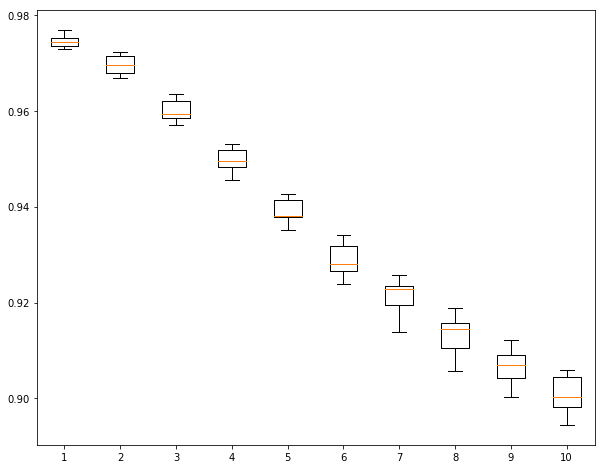

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Boxplot showing the accuracy for different minsize values on the train data
plt.boxplot(accuracy_train)
plt.show()

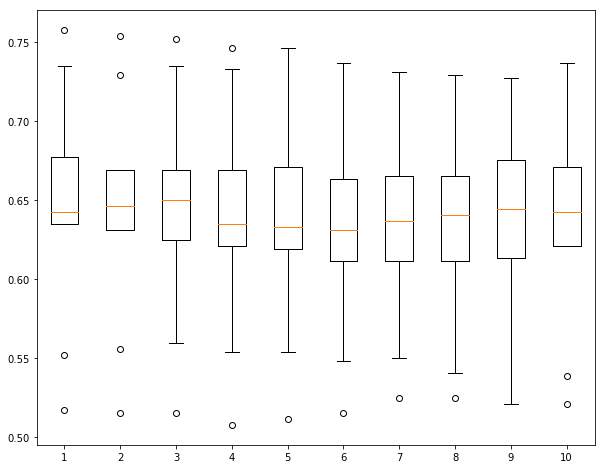

In [23]:
#Boxplot showing the accuracy for different minsize values on the test data
plt.boxplot(accuracy_test)
plt.show()

In [33]:
#From the boxplots it turns out that the accuracy is highest when the minimum size is set to 3
def getConfusionMatrix(d, l, root):
    matrix = [[0., 0.], [0., 0.]]
    correct = 0.
    false = 0.
    for point, label in zip(d, l):
        pred = root.classify(point)
        if label == pred:
            correct += 1
        else:
            false += 1
        
        if label == '-1':
            label_i = 0
        else:
            label_i = 1
        
        if pred == '-1':
            pred_i = 0
        else:
            pred_i = 1
        matrix[label_i][pred_i] += 1
    return matrix


minSize = 3
allBinary = [ BinaryNode for i in range(l_train.size) ]
train_root = c45(d_train,l_train, allBinary, minSize)

labels = ["no", "yes"]
matrix = getConfusionMatrix(d_test, l_test, train_root)

In [32]:
row_format ="{:>15}" * (len(labels) + 1)
print row_format.format("", *labels)
for label, result in zip(labels, matrix):
    print row_format.format(label, *result)
    
precision = matrix[1][1] / (matrix[0][1] + matrix[1][1])
print "The precision is: " + str(precision)

recall = matrix[1][1] / (matrix[1][0] + matrix[1][1])
print "The recall is: " + str(recall)

accuracy = (matrix[0][0] + matrix[1][1])/(matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1])
print "The accuracy is: " + str(accuracy)


                            no            yes
             no         3795.0          496.0
            yes          152.0          847.0
The precision is: 0.630677587491
The recall is: 0.847847847848
The accuracy is: 0.877504725898


### Continuous values

Until now, we have only dealt with categorical features. In the next part of the lab, you will deal with mixed categorical and continuous features.

One way to deal with continuous features is to split the dataset based on whether the feature is larger than a certain threshold, or not. The number of possible threshold values to consider is, of course, infinite in theory, but when deciding what the threshold value should be, based on a training dataset, only threshold values that will result in a different classification of those training examples matter: those are values that are smaller than one datapoint's feature value and larger than another's. Moreover, when considering a threshold in between two feature values, any value of the threshold in that range will result in the same classification, but to maximise generalisation it makes sense to maximise the margin: that is, to take a threshold value that is in the middle between the two.

Also note that it only makes sense to consider ranges of feature values that are disjoint, i.e., consider thresholds that are in the middle between neighbouring datapoints (along that feature's dimension), not in the middle between any pair of datapoints.

**Question 3 [10 credits]**. You guessed it, implement a node ```ContNode``` that selects a threshold value based on its training subset and classifies new datapoints based on whether they are smaller than that value, or not.

In [14]:
# This code must be modified.

class ContNode(Node):
    """Make a binary decision based on a threshold, for the value of the given feature"""
    def __init__(self, inputs, targets, feature):
        self.feature = feature
        self.IG      = 0.0
        self.H       = entropy(targets)                     # Entropy of unsplit data
        self.inputs  = inputs
        self.targets = targets

        # Your code must fill in self.value here
        
    def entropy(self):
        return self.H
    
    def informationGain(self):
        """Return the entropy gain of splitting the given data according to 
        the specified feature and value"""
        return self.IG
    
    def classify(self, x):
        if x[self.feature] >= self.value:
            return self.children[0].classify(x)
        else:
            return self.children[1].classify(x)
        
    def __str__(self):
        return "=> threshold decision: %s >= %f" % (fname[self.feature],self.value)
    

## Classification based on mixed features

The following dataset contains 14 features describing people's situation, and the classification task is to predict whether they earn more than \$50k a year or not. The categorical decision nodes we implemented above can work with any representation of categorical data, but the continuous decision node requires a numerical representation of the feature. Numpy arrays cannot easily contain both strings and numbers, and so to simplify our life, we converted the dataset to 

To allow our classifier to work with mixed features, we use a numerical representation of the categorical features in the following. So, let's first load the data:

In [16]:
# This code is given

income = np.load('income.npz')
print income.keys()
inputs = income['inputs']
targets = income['targets']
fname = income['fnames']
ftypes = income['ftypes']

print ftypes

['inputs', 'catindices', 'fnames', 'targets', 'ftypes']
['continuous' 'categorical' 'continuous' 'categorical' 'continuous'
 'categorical' 'categorical' 'categorical' 'categorical' 'categorical'
 'continuous' 'continuous' 'continuous' 'categorical']


**Question 4 [10 credits]** Take 1000 training datapoints at random from the dataset, and another 1000 test points that are distinct from those (don't mix train and test). Train a decision tree on the train set and report the confusion matrix obtained on the test set. What are the obtained precision, recall and accuracy? 

In [ ]:
# Answer to Q4

featureType = [ ContNode if ftypes[i]=='continuous' else BinaryNode for i in range(len(ftypes)) ]
tree = c45(inputs[:10000,:],targets[:10000],100,featureType)
prettyPrint(tree)